In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.gridspec as gridspec

import matplotlib.font_manager as fm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


In [2]:
N = 50000
D_factor = 10
D_noise = 20
D = D_factor + D_noise
P = 3

V = np.abs(np.random.normal(1.5, 0.5, size=(P,D_factor)))
Z = np.abs(np.random.normal(0.5, size=(N,P)))

ZV = Z.dot(V)

X = np.zeros((N, D_factor+D_noise))
X = np.random.poisson(1.,size=(N,D_noise+D_factor))
X[:, ::3] = np.random.poisson(ZV*np.exp(ZV/np.mean(ZV)/10)+(ZV/np.mean(ZV)/10)**2)
# Test taking in from tf.dataset, don't pre-batch
data_structured = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data_structured = data_structured.batch(1000)

data_noise = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(1.0, size=(N, D)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data_noise = data_noise.batch(1000)

X_nonlinear = np.random.poisson(1.,size=(N,D_noise+D_factor))
X_nonlinear[:, ::3] = np.random.poisson(ZV*np.exp(ZV/np.mean(ZV)/10)+(ZV/np.mean(ZV)/10)**2)

data_nonlinear = tf.data.Dataset.from_tensor_slices(
    {
        'data': X_nonlinear,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data_nonlinear = data_nonlinear.batch(1000)


In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data_structured, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    scale_rates=True, 
    u_tau_scale=1.0/P/D/np.sqrt(N)*1e-3,
    dtype=tf.float64)

factor_noise = PoissonMatrixFactorization(
    data_noise, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    scale_rates=True, 
    u_tau_scale=1.0/P/D/np.sqrt(N)*1e-3,
    dtype=tf.float64)

factor_nonlinear = PoissonMatrixFactorization(
    data_nonlinear, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    scale_rates=True, 
    u_tau_scale=1.0/P/D/np.sqrt(N)*1e-3,
    dtype=tf.float64)

Feature dim: 30 -> Latent dim 3
Feature dim: 30 -> Latent dim 3
Feature dim: 30 -> Latent dim 3


In [4]:
losses = factor_noise.calibrate_advi(
    num_epochs=100, rel_tol=1e-4, learning_rate=.2)

W0530 15:37:09.115239 4597792192 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 40.227211285069586
Epoch 1: average-batch loss: 38.63434095949519 last batch loss: 37.614000802521375
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 36.87081927939354 last batch loss: 36.38900085094313
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 36.38110081131288 last batch loss: 36.31492726926531
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 36.33984027504725 last batch loss: 36.26552653316625
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 36.323253245119474 last batch loss: 36.28486373564741
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 36.32109820618198 last batch loss: 36.27705305178033
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 36.32408562478795 last batch loss: 36.26415188098449
We are in a loss plateau learning rate: 0.05 loss: 36.3008501686457
Restoring from a checkpoint - loss: 36.30488790816876
Epoch 8: average-batch loss: 

Epoch 76: average-batch loss: 36.34549413684911 last batch loss: 36.28767171220813
We are in a loss plateau learning rate: 2.9802322387695314e-09 loss: 36.41845781554978
Restoring from a checkpoint - loss: 36.34667471395487
Epoch 77: average-batch loss: 36.350217718268496 last batch loss: 36.3159546918129
Epoch 78: average-batch loss: 36.34135010765712 last batch loss: 36.29167993740045
Epoch 79: average-batch loss: 36.333983583854256 last batch loss: 36.24640718845882
Epoch 80: average-batch loss: 36.33365175281067 last batch loss: 36.300757570689896
Epoch 81: average-batch loss: 36.334287857919136 last batch loss: 36.283229325814006
We are in a loss plateau learning rate: 7.450580596923829e-10 loss: 36.29278340057251
Restoring from a checkpoint - loss: 36.285790111094094
Epoch 82: average-batch loss: 36.323574109767776 last batch loss: 36.25347154564905
Epoch 83: average-batch loss: 36.328381376857024 last batch loss: 36.31014898947462
Epoch 84: average-batch loss: 36.33331078079018 

In [5]:
waic = factor_noise.waic()
print(waic)

{'waic': 353809.8553631659, 'se': 1827.6975890725741, 'lppd': -37666.45799044033, 'pwaic': 139238.4696911426}


In [6]:
losses = factor.calibrate_advi(
    num_epochs=100, rel_tol=1e-4, learning_rate=.2)




Initial loss: 53.43836815246557
Epoch 1: average-batch loss: 51.53463674372346 last batch loss: 50.319206562134106
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 48.89150204921982 last batch loss: 46.524914563095656
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 45.257710762608916 last batch loss: 44.9399700522429
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 44.8193747679146 last batch loss: 44.83130992575832
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 44.75436915885021 last batch loss: 44.83616806160634
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 44.57230968174225 last batch loss: 44.494536110172916
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 44.3207847118424 last batch loss: 44.28986336010614
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 44.2049687595803 last batch loss: 44.29431408108578
Saved a checkpoint: ./.tf_ckpts/

Epoch 74: average-batch loss: 44.07547503253762 last batch loss: 44.133951901095585
Epoch 75: average-batch loss: 44.04019026834619 last batch loss: 44.168300030796225
Epoch 76: average-batch loss: 44.04168030148163 last batch loss: 44.23292614296881
Epoch 77: average-batch loss: 44.05714846930371 last batch loss: 44.18141139136082
Epoch 78: average-batch loss: 44.06624911124803 last batch loss: 44.15541157177278
We are in a loss plateau learning rate: 4.76837158203125e-08 loss: 44.05182762044682
Restoring from a checkpoint - loss: 44.049884124094575
Epoch 79: average-batch loss: 44.044930149081004 last batch loss: 44.14758622521288
Epoch 80: average-batch loss: 44.036374136606646 last batch loss: 44.18095261187027
Epoch 81: average-batch loss: 44.04760382912968 last batch loss: 44.14787745682186
Epoch 82: average-batch loss: 44.03184128352037 last batch loss: 44.145375802995765
Epoch 83: average-batch loss: 44.026053290267875 last batch loss: 44.1523466684538
Saved a checkpoint: ./.tf

In [7]:
losses = factor_nonlinear.calibrate_advi(
    num_epochs=100, rel_tol=1e-4, learning_rate=.2)


Initial loss: 53.58335401256711
Epoch 1: average-batch loss: 51.52943338137632 last batch loss: 50.201829116882145
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 49.015306058863516 last batch loss: 46.030778177390744
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 45.20961013243661 last batch loss: 44.72393196170943
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 44.82896763729056 last batch loss: 44.62365647917271
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 44.78187201096901 last batch loss: 44.54193177443338
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 44.61279322894156 last batch loss: 44.339575568543445
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 44.41914950497526 last batch loss: 44.12339042964672
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 44.26882333680165 last batch loss: 44.027627409646556
Saved a checkpoint: ./.tf_c

Epoch 74: average-batch loss: 44.069163834893544 last batch loss: 43.86418272392992
Epoch 75: average-batch loss: 44.048820312168544 last batch loss: 43.87101889228251
Epoch 76: average-batch loss: 44.04241352826199 last batch loss: 43.86905293219318
Epoch 77: average-batch loss: 44.038783985453954 last batch loss: 43.84819313694166
Epoch 78: average-batch loss: 44.03820844138916 last batch loss: 43.86210989743796
Saved a checkpoint: ./.tf_ckpts/chkpt-25
Epoch 79: average-batch loss: 44.04657619435039 last batch loss: 43.836421908185976
We are in a loss plateau learning rate: 1.9073486328125e-07 loss: 44.06780358727362
Restoring from a checkpoint - loss: 44.0861601773344
Epoch 80: average-batch loss: 44.07704381610887 last batch loss: 43.87344206127937
Epoch 81: average-batch loss: 44.04664084933701 last batch loss: 43.898407103253355
Epoch 82: average-batch loss: 44.042051038086754 last batch loss: 43.903911447876524
Epoch 83: average-batch loss: 44.04278231251546 last batch loss: 43.

In [8]:
surrogate_samples = factor.surrogate_distribution.sample(1000)
weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
intercept_data_structured = az.convert_to_inference_data(
    {
        r"": 
            (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor.norm_factor).numpy().T})

surrogate_samples = factor_noise.surrogate_distribution.sample(1000)
weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
intercept_data_noise = az.convert_to_inference_data(
    {
        r"": 
            (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor_noise.norm_factor).numpy().T})


surrogate_samples = factor_nonlinear.surrogate_distribution.sample(1000)
weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
intercept_data_nonlinear = az.convert_to_inference_data(
    {
        r"": 
            (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor_nonlinear.norm_factor).numpy().T})



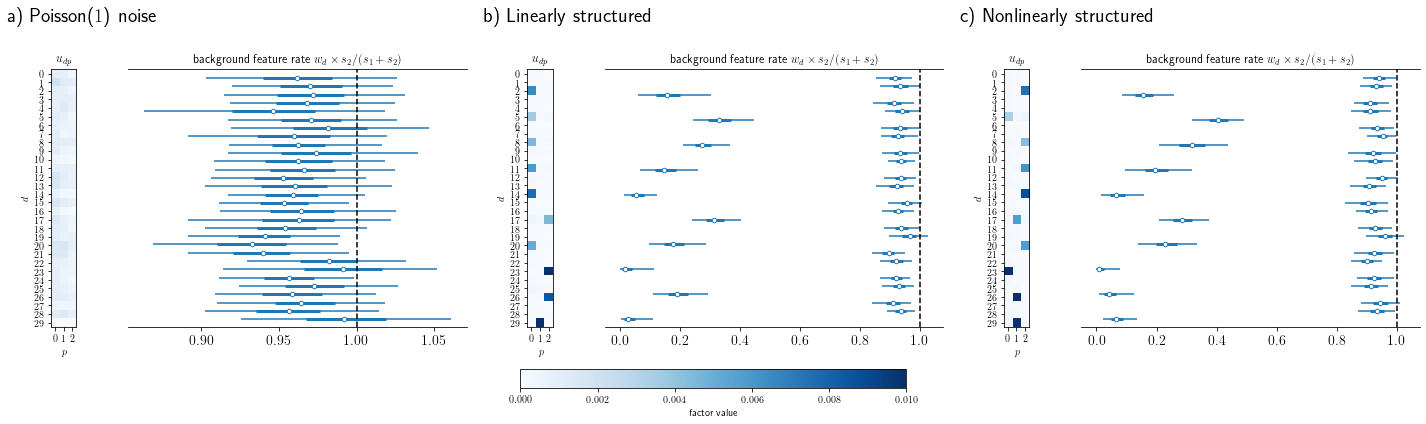

In [40]:
fig = plt.figure(constrained_layout=False, figsize=(20,6))
gs = fig.add_gridspec(3, 3, height_ratios=(0.08, 6, 0.3))
ax = []

ax += [fig.add_subplot(gs[0,0])]
txt = ax[-1].text(0,0,"a) Poisson($1$) noise", clip_on=False, fontsize=20)
ax[-1].axis('off')

ax += [fig.add_subplot(gs[0,1])]
txt = ax[-1].text(0,0,"b) Linearly structured", clip_on=False, fontsize=20)
ax[-1].axis('off')

ax += [fig.add_subplot(gs[0,2])]
txt = ax[-1].text(0,0,"c) Nonlinearly structured", clip_on=False, fontsize=20)
ax[-1].axis('off')

gs0 = gs[1, 0].subgridspec(1,2, width_ratios=[1,3])
ax+= [fig.add_subplot(gs0[0, 0])]
pcm = ax[-1].imshow(factor_noise.encoding_matrix().numpy()[::-1,:], vmin=0, vmax=0.01, cmap="Blues")
ax[-1].set_title(r"$u_{dp}$")
ax[-1].set_xticks(range(P))
ax[-1].set_yticks(range(D))
ax[-1].set_ylabel(r"$d$")
ax[-1].set_xlabel(r"$p$")
ax[-1].grid(which='minor', color='g', linestyle='-', linewidth=2)
#fig.colorbar(pcm, ax=ax[-1], location='left', shrink=0.5)
#ax[-1].set_title("a) Noise factorization", fontsize=20)

ax+= [fig.add_subplot(gs0[0, 1])]
az.plot_forest(intercept_data_noise, ax=ax[-1])
ax[-1].set_title(r"background feature rate $w_d\times s_2/(s_1+s_2)$")
ax[-1].set_ylim((-0.014,.466))
ax[-1].axvline(1.0, linestyle='dashed', color="black")

#

gs1 = gs[1, 1].subgridspec(1,2, width_ratios=[1,3])
ax = []
ax+= [fig.add_subplot(gs1[0, 0])]


pcm = ax[-1].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, vmax=0.01, cmap="Blues")
ax[-1].set_title(r"$u_{dp}$")

ax[-1].set_xticks(range(P))
ax[-1].set_yticks(range(D))
ax[-1].set_ylabel(r"$d$")
ax[-1].set_xlabel(r"$p$")
#fig.colorbar(pcm, ax=ax[-1], location='left', shrink=0.5)
ax+= [fig.add_subplot(gs1[0, 1])]
az.plot_forest(intercept_data_structured, ax=ax[-1])
ax[-1].set_title(r"background feature rate $w_d\times s_2/(s_1+s_2)$")
ax[-1].set_ylim((-0.014,.466))
ax[-1].axvline(1.0, linestyle='dashed', color="black")

gs2 = gs[1, 2].subgridspec(1,2, width_ratios=[1,3])
ax = []
ax+= [fig.add_subplot(gs2[0, 0])]
pcm = ax[-1].imshow(factor_nonlinear.encoding_matrix().numpy()[::-1,:], vmin=0, vmax=0.01, cmap="Blues")
ax[-1].set_title(r"$u_{dp}$")

ax[-1].set_xticks(range(P))
ax[-1].set_yticks(range(D))
ax[-1].set_ylabel(r"$d$")
ax[-1].set_xlabel(r"$p$")
#fig.colorbar(pcm, ax=ax[-1], location='left', shrink=0.5)
#ax[-1].set_title("a) Noise factorization", fontsize=20)

ax+= [fig.add_subplot(gs2[0, 1])]
az.plot_forest(intercept_data_nonlinear, ax=ax[-1])
#ax[-1].set_xlabel("background rate")
ax[-1].set_ylim((-0.014,.466))
ax[-1].set_title(r"background feature rate $w_d \times s_2/(s_1+s_2)$")
ax[-1].axvline(1.0, linestyle='dashed', color="black")

# colorbar

ax += [fig.add_subplot(gs[2, :])]
ax[-1].set_axis_off()
fig.colorbar(pcm, ax=ax[-1], orientation="horizontal", fraction=1.5, label="factor value")


plt.tight_layout()
plt.savefig('simulations_sepmf.pdf', bbox_inches='tight')
